In [1]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging,
    LlamaForSequenceClassification,
    LlamaTokenizer
)
from peft import LoraConfig
from trl import SFTTrainer
from accelerate import Accelerator
from torch.utils.data import DataLoader
from datasets import Dataset



/home/linux1/miniconda3/envs/night/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/linux1/miniconda3/envs/night/lib/python3.9/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/linux1/miniconda3/envs/night/lib/python3.9/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


# Step 0. prepare llama training model and env
(not finish)

In [ ]:
# ! conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch-nightly -c nvidia
# ! pip install sentencepiece
# ! pip install  trl 
# ! pip install tensorboard
# ! pip install matplotlib

# step 1. datasets

In [5]:
# Model from Hugging Face hub
base_model= "meta-llama/Llama-2-7b-hf"

# The instruction dataset to use
dataset_name1 = "/home/linux1/BOX/modeling23/Data/pap/train-dev-test-split-filtered/binary/train.csv"
dataset_name2 = "/home/linux1/BOX/modeling23/Data/pap/train-dev-test-split-filtered/binary/dev.csv"
dataset_name3 = "/home/linux1/BOX/modeling23/Data/pap/train-dev-test-split-filtered/binary/test.csv"

In [6]:
dataset_train = load_dataset("csv", data_files = dataset_name1 , split = "train")
dataset_eval = load_dataset("csv", data_files = dataset_name2 ,split='train')
dataset_test = load_dataset("csv", data_files = dataset_name3 ,split='train')

print(f'Number of prompts: {len(dataset_train)}')
print(f'Column names are: {dataset_train.column_names}')

Number of prompts: 1386
Column names are: ['text', 'original_label', 'label']


# Step 2. Get the model

In [7]:
accelerator = Accelerator()
tokenizer= AutoTokenizer.from_pretrained(base_model)

In [8]:
def set_all_model_need(base_model):
    compute_dtype = getattr(torch, "float16")

    id2label = {0: "implausible", 1: "plausible"}
    label2id = {"implausible": 0, "plausible": 1}

    quant_config = BitsAndBytesConfig(
        load_in_8bit=True,
        bnb_8bit_quant_type="nf8",
        bnb_8bit_compute_dtype=compute_dtype,
        bnb_8bit_use_double_quant=False,
    )

    model = LlamaForSequenceClassification.from_pretrained(
        base_model,
        quantization_config=quant_config,
        device_map={"": 0},
        num_labels=2, id2label=id2label, label2id=label2id
        )
    model.config.use_cache = False
    model.config.pretraining_tp = 1
    print("Original number of parameters:", sum(p.numel() for p in model.parameters()))
    print(model)
    return model

In [9]:
model=set_all_model_need(base_model)

Loading checkpoint shards: 100%|██████████| 2/2 [00:13<00:00,  6.75s/it]
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-2-7b-hf and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Original number of parameters: 6607351808
LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear8bitLt(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear8bitLt(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear8bitLt(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
    

# Step 3. Get tokenizer and dataloader

### re-built dataset

In [10]:
label2id = {"implausible": 0, "plausible": 1}
train_labels = [label2id[label] for label in dataset_train["original_label"]]
eval_labels = [label2id[label] for label in dataset_eval["original_label"]]
test_labels = [label2id[label] for label in dataset_test["original_label"]]

new_train_dataset =  Dataset.from_dict({
    'text': dataset_train['text'],
    'labels': train_labels # Update 'original_label' with train_list
})

new_eval_dataset =  Dataset.from_dict({
    'text': dataset_eval['text'],
    'labels': eval_labels 
})

new_test_dataset =  Dataset.from_dict({
    'text': dataset_test['text'],
    'labels': test_labels 
})

### tokenize text

In [11]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True,return_tensors="pt").to("cuda") 

In [12]:
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"
model.config.pad_token_id = model.config.eos_token_id

In [13]:
tokenized_datasets_train =new_train_dataset.map(tokenize_function, batched=True,batch_size=len(new_train_dataset))
tokenized_datasets_train  =tokenized_datasets_train .remove_columns(["text"])

tokenized_datasets_eval =new_eval_dataset.map(tokenize_function, batched=True,batch_size=len(new_eval_dataset))
tokenized_datasets_eval =tokenized_datasets_eval.remove_columns(["text"])

tokenized_datasets_test =new_test_dataset.map(tokenize_function, batched=True,batch_size=len(new_test_dataset))
tokenized_datasets_test =tokenized_datasets_test.remove_columns(["text"])

print(tokenized_datasets_train [0])
print(type(tokenized_datasets_train [0]))
print(tokenized_datasets_train [0]['input_ids'])   
print(type(tokenized_datasets_train [0]['input_ids']))
print(tokenized_datasets_train [0]['input_ids'][0])
print(type(tokenized_datasets_train [0]['input_ids'][0]))

Map: 100%|██████████| 174/174 [00:00<00:00, 14135.37 examples/s]

{'labels': 1, 'input_ids': [1, 2318, 27474, 3769, 2, 2, 2, 2, 2, 2, 2, 2, 2], 'attention_mask': [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
<class 'dict'>
[1, 2318, 27474, 3769, 2, 2, 2, 2, 2, 2, 2, 2, 2]
<class 'list'>
1
<class 'int'>


### dataloader

In [14]:
## collate_fn
def collate(batch):  #to padding the features data
    labels=[]
    ids_all=[]
    attention_mask=[]
    #print(batch)

    for i in batch:
        #print('i:',i)
        a=torch.tensor(i['input_ids'])
        b=torch.tensor(i['attention_mask'])
        c=torch.tensor(i['labels'])
            
        labels.append(c) #(label)
        ids_all.append(a) #(input_ids)
        attention_mask.append(b) #(attention_mask)

    batch_of_labels=torch.stack(labels)
    batch_of_attention_mask=torch.stack(attention_mask)
    batch_of_ids=torch.stack(ids_all)
    batch_of_text={'input_ids':batch_of_ids,'attention_mask':batch_of_attention_mask}

    return batch_of_labels,batch_of_text

In [15]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(tokenized_datasets_train, shuffle=True, batch_size=2, collate_fn=collate)
eval_dataloader = DataLoader(tokenized_datasets_eval, shuffle=True, batch_size=len(eval_labels), collate_fn=collate)
test_dataloader = DataLoader(tokenized_datasets_test, shuffle=True, batch_size=len(test_labels), collate_fn=collate)

# Step 3: Check base model

In [16]:
import numpy as np
def get_accuracy(acc_preds, acc_labels):
    preds_np = acc_preds.detach().cpu().numpy()
    preds = np.array([ i.argmax() for i in preds_np])
    labels = np.array(acc_labels.cpu())
    correct_count = (preds== labels).sum().item()
    total_count = len(preds)

    accuracy = correct_count / total_count
    #print(f"Accuracy: {accuracy:.3f}")
    return accuracy


def get_precision_recall(preds, labels,flag='true'):
    preds_np = preds.detach().cpu().numpy()
    preds = np.array([ i.argmax() for i in preds_np])
    labels = np.array(labels)
    # print(preds)
    # print(labels)

    true_positives = ((preds == 1) & (labels == 1)).sum().item()
    false_positives = ((preds == 1) & (labels == 0)).sum().item()
    false_negatives = ((preds == 0) & (labels == 1)).sum().item()
    true_negatives = ((preds == 0) & (labels == 0)).sum().item()

    if flag=='true':   
        #print('---positive is plausible') 
        precision = true_positives / (true_positives + false_positives) 
        recall = true_positives / (true_positives + false_negatives) 
    elif flag=='false':
        #print('---positive is implausible')
        precision = true_negatives  / (true_negatives  + false_negatives ) 
        recall = true_negatives  / (true_negatives  +false_positives ) 

    f_score = (2 * precision * recall) / (precision + recall)
    # print(f"Precision: {precision:.3f}")
    # print(f"Recall: {recall:.3f}")
    # print(f"F-score: {f_score:.3f}")
    
    return precision, recall, f_score

In [17]:
with torch.no_grad():
    for labels,text in test_dataloader:
        logits = model(**text).logits
        the_labels=labels
        a=get_accuracy(logits, the_labels)
        print(f"Accuracy: {a:.3f}")
        precision, recall, f_score=get_precision_recall(logits, the_labels)
        print('---positive is plausible') 
        print(f"Precision: {precision:.3f}")
        print(f"Recall: {recall:.3f}")
        print(f"F-score: {f_score:.3f}")
        precision, recall, f_score=get_precision_recall(logits, the_labels,flag='false')
        print('---positive is implausible')
        print(f"Precision: {precision:.3f}")
        print(f"Recall: {recall:.3f}")
        print(f"F-score: {f_score:.3f}")


Accuracy: 0.351
---positive is plausible
Precision: 0.368
Recall: 0.263
F-score: 0.307
---positive is implausible
Precision: 0.340
Recall: 0.456
F-score: 0.389


# Step 5. set peft

In [18]:
from peft import (
    get_peft_model,
    LoraConfig,
    TaskType,
    prepare_model_for_int8_training,
    PeftModel
)

In [19]:
def create_peft_config(model):

    peft_config = LoraConfig(
        task_type=TaskType.CAUSAL_LM,
        inference_mode=False,
        r=8,
        lora_alpha=32,
        lora_dropout=0.05,
        target_modules = ["q_proj", "v_proj"]
    )

    model = get_peft_model(model, peft_config)
    model.print_trainable_parameters()
    return model, peft_config

# create peft config
model, lora_config = create_peft_config(model)

trainable params: 4,194,304 || all params: 6,611,546,112 || trainable%: 0.06343907958816639


# Step 6. train

In [20]:
from torch.optim import AdamW
from tqdm.auto import tqdm
import torch.nn as nn
from transformers import get_scheduler

optimizer = AdamW(model.parameters(), lr=1e-4 ) #5e-5)
loss_fn = nn.CrossEntropyLoss()

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)

#learning rate adjustment:
lr_scheduler = get_scheduler( 
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [21]:
train_dataloader, eval_dataloader, model, optimizer = accelerator.prepare(
    train_dataloader, eval_dataloader, model, optimizer
)
loss_list=[]
accuracy_list=[]
loss_sum=0
accuracy_sum=0


In [23]:
# train
progress_bar = tqdm(range(int(num_training_steps/30)))

flag=0
for epoch in range(num_epochs):
    for thelabels,text in train_dataloader:
        model.train()
        outputs = model(**text)
        logits = outputs.logits
        loss = loss_fn(logits.squeeze(), thelabels)
        accelerator.backward(loss)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        flag+=1

        loss_sum += int(loss.item())
        a=get_accuracy(logits, thelabels)
        accuracy_sum+=a

        if flag%30==0:
            print(flag,loss_sum/flag,accuracy_sum/flag)
            loss_list.append(loss_sum/flag)
            accuracy_list.append(accuracy_sum/flag)
            progress_bar.update(1)

  1%|▏         | 1/69 [00:23<27:04, 23.89s/it]

30 1.2 0.43333333333333335


  3%|▎         | 2/69 [00:45<25:16, 22.63s/it]

60 1.1 0.4583333333333333


  4%|▍         | 3/69 [01:07<24:30, 22.28s/it]

90 0.8111111111111111 0.49444444444444446


  6%|▌         | 4/69 [01:31<24:44, 22.84s/it]

120 0.7166666666666667 0.5041666666666667


  7%|▋         | 5/69 [01:53<24:01, 22.53s/it]

150 0.6133333333333333 0.54


  9%|▊         | 6/69 [02:15<23:34, 22.45s/it]

180 0.5333333333333333 0.5833333333333334


 10%|█         | 7/69 [02:37<23:00, 22.27s/it]

210 0.49047619047619045 0.5952380952380952


 12%|█▏        | 8/69 [02:58<22:23, 22.02s/it]

240 0.4791666666666667 0.6020833333333333


 13%|█▎        | 9/69 [03:20<21:53, 21.89s/it]

270 0.43333333333333335 0.6333333333333333


 14%|█▍        | 10/69 [03:42<21:27, 21.83s/it]

300 0.39666666666666667 0.6516666666666666


 16%|█▌        | 11/69 [04:03<21:03, 21.79s/it]

330 0.38181818181818183 0.6666666666666666


 17%|█▋        | 12/69 [04:25<20:35, 21.67s/it]

360 0.35555555555555557 0.6791666666666667


 19%|█▉        | 13/69 [04:46<20:09, 21.61s/it]

390 0.34615384615384615 0.6948717948717948


 20%|██        | 14/69 [05:09<20:01, 21.85s/it]

420 0.3333333333333333 0.7047619047619048


 22%|██▏       | 15/69 [05:31<19:48, 22.01s/it]

450 0.31777777777777777 0.7111111111111111


 23%|██▎       | 16/69 [05:53<19:20, 21.90s/it]

480 0.3104166666666667 0.715625


 25%|██▍       | 17/69 [06:14<18:50, 21.75s/it]

510 0.30392156862745096 0.7215686274509804


 26%|██▌       | 18/69 [06:36<18:36, 21.90s/it]

540 0.29074074074074074 0.725925925925926


 28%|██▊       | 19/69 [06:58<18:12, 21.85s/it]

570 0.2824561403508772 0.730701754385965


 29%|██▉       | 20/69 [07:19<17:44, 21.72s/it]

600 0.2733333333333333 0.7366666666666667


 30%|███       | 21/69 [07:41<17:18, 21.64s/it]

630 0.2619047619047619 0.7452380952380953


 32%|███▏      | 22/69 [08:03<17:00, 21.72s/it]

660 0.2590909090909091 0.7507575757575757


 33%|███▎      | 23/69 [08:25<16:40, 21.74s/it]

690 0.25217391304347825 0.7557971014492754


 35%|███▍      | 24/69 [08:46<16:17, 21.72s/it]

720 0.24305555555555555 0.7618055555555555


 36%|███▌      | 25/69 [09:08<15:54, 21.70s/it]

750 0.236 0.7686666666666667


 38%|███▊      | 26/69 [09:29<15:28, 21.59s/it]

780 0.22692307692307692 0.775


 39%|███▉      | 27/69 [09:51<15:03, 21.52s/it]

810 0.21975308641975308 0.778395061728395


 41%|████      | 28/69 [10:12<14:38, 21.44s/it]

840 0.2130952380952381 0.7833333333333333


 42%|████▏     | 29/69 [10:33<14:15, 21.38s/it]

870 0.20804597701149424 0.7879310344827586


 43%|████▎     | 30/69 [10:55<14:02, 21.59s/it]

900 0.20222222222222222 0.7933333333333333


 45%|████▍     | 31/69 [11:18<13:52, 21.91s/it]

930 0.1967741935483871 0.7983870967741935


 46%|████▋     | 32/69 [11:40<13:34, 22.01s/it]

960 0.19166666666666668 0.8041666666666667


 48%|████▊     | 33/69 [12:02<13:06, 21.85s/it]

990 0.18686868686868688 0.8085858585858586


 49%|████▉     | 34/69 [12:23<12:41, 21.74s/it]

1020 0.18333333333333332 0.8132352941176471


 51%|█████     | 35/69 [12:45<12:22, 21.83s/it]

1050 0.18 0.8166666666666667


 52%|█████▏    | 36/69 [13:06<11:55, 21.68s/it]

1080 0.175 0.8208333333333333


 54%|█████▎    | 37/69 [13:28<11:31, 21.60s/it]

1110 0.17207207207207206 0.8238738738738739


 55%|█████▌    | 38/69 [13:49<11:09, 21.60s/it]

1140 0.1675438596491228 0.8276315789473684


 57%|█████▋    | 39/69 [14:11<10:51, 21.73s/it]

1170 0.16495726495726495 0.8303418803418804


 58%|█████▊    | 40/69 [14:33<10:31, 21.79s/it]

1200 0.16166666666666665 0.8333333333333334


 59%|█████▉    | 41/69 [14:55<10:11, 21.84s/it]

1230 0.15934959349593497 0.8369918699186992


 61%|██████    | 42/69 [15:17<09:46, 21.73s/it]

1260 0.15714285714285714 0.8384920634920635


 62%|██████▏   | 43/69 [15:38<09:22, 21.64s/it]

1290 0.15503875968992248 0.8406976744186047


 64%|██████▍   | 44/69 [16:00<09:00, 21.61s/it]

1320 0.15303030303030302 0.843560606060606


 65%|██████▌   | 45/69 [16:21<08:36, 21.53s/it]

1350 0.1511111111111111 0.845925925925926


 67%|██████▋   | 46/69 [16:42<08:13, 21.45s/it]

1380 0.1492753623188406 0.8471014492753624


 68%|██████▊   | 47/69 [17:05<07:59, 21.77s/it]

1410 0.14609929078014183 0.8489361702127659


 70%|██████▉   | 48/69 [17:27<07:41, 21.96s/it]

1440 0.14305555555555555 0.8517361111111111


 71%|███████   | 49/69 [17:49<07:17, 21.86s/it]

1470 0.1401360544217687 0.8547619047619047


 72%|███████▏  | 50/69 [18:10<06:51, 21.64s/it]

1500 0.13733333333333334 0.8576666666666667


 74%|███████▍  | 51/69 [18:32<06:29, 21.64s/it]

1530 0.134640522875817 0.8601307189542484


 75%|███████▌  | 52/69 [18:53<06:06, 21.54s/it]

1560 0.13205128205128205 0.8628205128205129


 77%|███████▋  | 53/69 [19:14<05:44, 21.51s/it]

1590 0.12955974842767295 0.8650943396226415


 78%|███████▊  | 54/69 [19:36<05:22, 21.48s/it]

1620 0.1271604938271605 0.8675925925925926


 80%|███████▉  | 55/69 [19:58<05:02, 21.57s/it]

1650 0.12484848484848485 0.87


 81%|████████  | 56/69 [20:19<04:41, 21.63s/it]

1680 0.12261904761904761 0.8723214285714286


 83%|████████▎ | 57/69 [20:41<04:19, 21.64s/it]

1710 0.12046783625730995 0.874561403508772


 84%|████████▍ | 58/69 [21:03<03:58, 21.66s/it]

1740 0.11839080459770115 0.8761494252873563


 86%|████████▌ | 59/69 [21:24<03:36, 21.61s/it]

1770 0.11638418079096045 0.8779661016949153


 87%|████████▋ | 60/69 [21:45<03:13, 21.47s/it]

1800 0.11444444444444445 0.8797222222222222


 88%|████████▊ | 61/69 [22:07<02:51, 21.44s/it]

1830 0.11256830601092896 0.8816939890710382


 90%|████████▉ | 62/69 [22:28<02:29, 21.39s/it]

1860 0.110752688172043 0.8836021505376344


 91%|█████████▏| 63/69 [22:50<02:08, 21.45s/it]

1890 0.10899470899470899 0.8854497354497355


 93%|█████████▎| 64/69 [23:12<01:48, 21.73s/it]

1920 0.10729166666666666 0.8872395833333333


 94%|█████████▍| 65/69 [23:35<01:27, 21.96s/it]

1950 0.10564102564102563 0.8887179487179487


 96%|█████████▌| 66/69 [23:56<01:05, 21.88s/it]

1980 0.10505050505050505 0.8898989898989899


 97%|█████████▋| 67/69 [24:18<00:43, 21.77s/it]

2010 0.10348258706467661 0.891542288557214


 99%|█████████▊| 68/69 [24:40<00:21, 21.84s/it]

2040 0.10196078431372549 0.8928921568627451


100%|██████████| 69/69 [25:02<00:00, 21.84s/it]

2070 0.10048309178743961 0.8942028985507247


[1.2, 1.1, 0.8111111111111111, 0.7166666666666667, 0.6133333333333333, 0.5333333333333333, 0.49047619047619045, 0.4791666666666667, 0.43333333333333335, 0.39666666666666667, 0.38181818181818183, 0.35555555555555557, 0.34615384615384615, 0.3333333333333333, 0.31777777777777777, 0.3104166666666667, 0.30392156862745096, 0.29074074074074074, 0.2824561403508772, 0.2733333333333333, 0.2619047619047619, 0.2590909090909091, 0.25217391304347825, 0.24305555555555555, 0.236, 0.22692307692307692, 0.21975308641975308, 0.2130952380952381, 0.20804597701149424, 0.20222222222222222, 0.1967741935483871, 0.19166666666666668, 0.18686868686868688, 0.18333333333333332, 0.18, 0.175, 0.17207207207207206, 0.1675438596491228, 0.16495726495726495, 0.16166666666666665, 0.15934959349593497, 0.15714285714285714, 0.15503875968992248, 0.15303030303030302, 0.1511111111111111, 0.1492753623188406, 0.14609929078014183, 0.14305555555555555, 0.1401360544217687, 0.13733333333333334, 0.134640522875817, 0.13205128205128205, 0

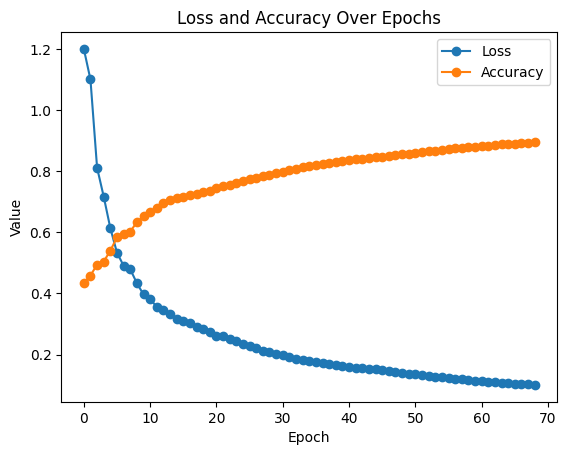

In [ ]:
print(loss_list)
print(accuracy_list)

import matplotlib.pyplot as plt

# Plotting the data
plt.plot(loss_list, label='Train_Loss', marker='o')
plt.plot(accuracy_list, label='Train_Accuracy', marker='o')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Loss and Accuracy Over Epochs')

# Adding a legend
plt.legend()

# Display the plot
plt.show()


In [25]:
# test after train 
with torch.no_grad():
    for labels,text in test_dataloader:
        logits = model(**text).logits
        the_labels=labels
        print(get_accuracy(logits, the_labels))
        print(get_precision_recall(logits, the_labels))
        print(get_precision_recall(logits, the_labels,flag='false'))

0.8563218390804598
(0.9069767441860465, 0.8210526315789474, 0.861878453038674)
(0.8068181818181818, 0.8987341772151899, 0.8502994011976047)


In [26]:
model.merge_and_unload()

/home/linux1/miniconda3/envs/night/lib/python3.9/site-packages/peft/tuners/lora/bnb.py:72: UserWarning: Merge lora module to 8-bit linear may get different generations due to rounding errors.
  warnings.warn(


LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear8bitLt(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear8bitLt(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear8bitLt(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNo

In [27]:
with torch.no_grad():
    for labels,text in test_dataloader:
        logits = model(**text).logits
        the_labels=labels
        print(get_accuracy(logits, the_labels))
        print(get_precision_recall(logits, the_labels))
        print(get_precision_recall(logits, the_labels,flag='false'))

0.8390804597701149
(0.8941176470588236, 0.8, 0.8444444444444443)
(0.7865168539325843, 0.8860759493670886, 0.8333333333333333)


# save

In [36]:
save_dir= "./models_hf/after_finetune_peft_7B_merge"
model.save_pretrained(save_dir,safe_safetensors=True)

In [29]:
save_dir_tokenizer= save_dir+"/tokenizer"
tokenizer.save_pretrained(save_dir_tokenizer)

('./models_hf/after_finetune_peft_7B_2merge/tokenizer/tokenizer_config.json',
 './models_hf/after_finetune_peft_7B_2merge/tokenizer/special_tokens_map.json',
 './models_hf/after_finetune_peft_7B_2merge/tokenizer/tokenizer.model',
 './models_hf/after_finetune_peft_7B_2merge/tokenizer/added_tokens.json',
 './models_hf/after_finetune_peft_7B_2merge/tokenizer/tokenizer.json')

##  Problem: Loading the model after saving will encounter problems:
### 1. save model before using model.merge_and_unload() : 
#### Reload success. But after saving and loading the model, the performance is not the same (almost as bad as the original model).
### 2. save model after using model.merge_and_unload(): 
#### Reload fail. Get error: SafetensorError: Error while deserializing header: InvalidHeaderDeserialization

This problem has not been solved yet.
